In [ ]:
import pandas as pd
import matplotlib as mp
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb

In [ ]:
pip install fast_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 615 kB/s 


In [ ]:
cardf=pd.read_csv('cardf_new.csv')

In [ ]:
#remove name, owner and seller type
#add no of years
#convert transmission to numbers
#convert fuel type to numbers
cardf.head()


,Selling_price,Present_new,Kms_driven,total_years,Fuel_type_Diesel,Fuel_type_LPG,Fuel_type_Petrol,Transmission_Manual
0,120000,126000,50000,17,1,0,0,1
1,50000,52500,120000,20,1,0,0,1
2,430000,451500,50000,10,0,0,1,1
3,1200000,1260000,60000,10,0,0,1,0
4,1295000,1359750,58000,11,1,0,0,0


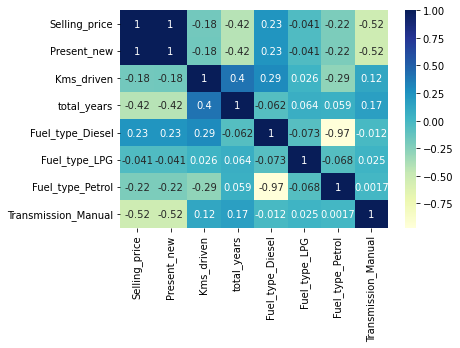

In [ ]:
dataplot = sb.heatmap(cardf.corr(), cmap="YlGnBu", annot=True)

In [ ]:
X=cardf.iloc[:,1:]
Y=cardf.iloc[:,0]

In [ ]:
Y.head()

0     120000
1      50000
2     430000
3    1200000
4    1295000
Name: Selling_price, dtype: int64

In [ ]:
np.all(np.isfinite(cardf))

True

In [ ]:
np.any(np.isnan(cardf))

False

In [ ]:
cardf.dropna(inplace=True)

In [ ]:
check_nan = cardf.isnull().values.any()
print(check_nan)

False


In [ ]:
np.isnan(cardf.values.any())

False

In [ ]:
cardf.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
#Feature importance
from sklearn.ensemble import ExtraTreesRegressor
model=ExtraTreesRegressor()
model.fit(X,Y)

ExtraTreesRegressor()

In [ ]:
from fast_ml.model_development import train_valid_test_split

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = train_valid_test_split(cardf, target = 'Selling_price', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(9319, 7)
(9319,)
(1165, 7)
(1165,)
(1165, 7)
(1165,)


(None, None)

In [ ]:
#DECISION TREE
from sklearn.tree import DecisionTreeRegressor
tree_reg=DecisionTreeRegressor(random_state=42) # random state
tree_reg.fit(X_train,Y_train)


DecisionTreeRegressor(random_state=42)

In [17]:
y_pred_dtr = tree_reg.predict(X_test)

from sklearn.metrics import r2_score
r2_score(Y_test, y_pred_dtr)

0.9536272635332643

In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [14]:
rf.fit(X_train, Y_train)


RandomForestRegressor(random_state=42)

In [ ]:

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
base_accuracy = evaluate(rf, X_valid, Y_valid)
    

Model Performance
Average Error: 617.4720 degrees.
Accuracy = 99.93%.


In [ ]:
#RANDOMIZED SEARCH FOR HYPERPARAMETER TUNING
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
print(rf_random.best_params_)

{'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}


In [ ]:
# comparing the normal Random forest model (base_model) with the tuned random forest

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_valid, Y_valid)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_valid, Y_valid)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 2449.5353 degrees.
Accuracy = 98.99%.
Model Performance
Average Error: 2565.6082 degrees.
Accuracy = 98.97%.
Improvement of -0.02%.


In [ ]:
# comparing the normal Random forest model (base_model) with the tuned random forest

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, Y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, Y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 1565.9500 degrees.
Accuracy = 99.75%.
Model Performance
Average Error: 2103.6103 degrees.
Accuracy = 99.64%.
Improvement of -0.12%.


In [15]:
#LINEAR REGRESSION

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
# fit
lm.fit(X_train, Y_train)
# predict 
y_pred = lm.predict(X_test)
# metrics
from sklearn.metrics import r2_score
print(r2_score(y_true=Y_test, y_pred=y_pred))


0.9983764581956106


In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
#XGBOOST

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import r2_score
dtrain = xgb.DMatrix(X_train, label=Y_train)
dval = xgb.DMatrix(X_valid, label=Y_valid)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [ ]:
params = {'learning_rate': 0.001, 'max_depth': 6}

model = xgb.train(params, dtrain, evals=[(dval, 'eval')], num_boost_round=1000, early_stopping_rounds=10, verbose_eval=False)

In [ ]:
y_true = np.array(Y_test, dtype=np.float)
y_pred = np.array(model.predict(dtest), dtype=np.float)

In [ ]:
print("R^2 Score: {:.4f}".format(r2_score(y_true, y_pred)))

R^2 Score: 0.7274
